## Summary of Notebook Three
This notebook picks up where notebooks one and two left off. Fake voices generated from notebook one and Real voices obtained from notebook two will be preprocessed. After preprocessing, A neural network will be created. The goal is to train a machine learning model that can distinguish between fake and real audio. The model will be evaluated using the F1 score and confusion matrix.

# Importing Necesssary Modules

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from keras.metrics import F1Score

In [ ]:
from IPython import display

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
generic_sample = '/content/drive/MyDrive/MyTTSDataset_6/generated_speeches/generated_speech_101.wav'
display.Audio(generic_sample)

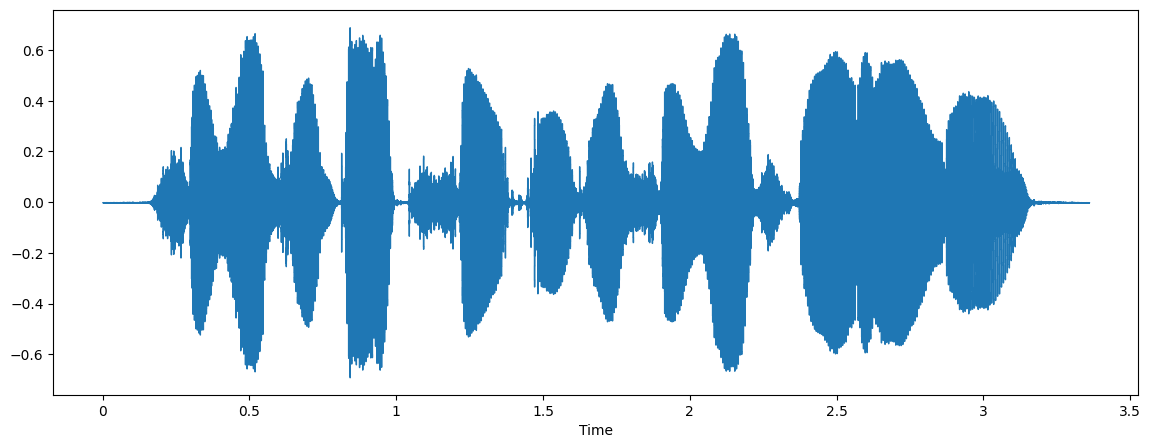

In [ ]:
sample, sr = librosa.load(generic_sample)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample, sr=sr)

In [ ]:
real_sample = '/content/drive/MyDrive/common_voice_13_0/sample_110.mp3'
display.Audio(real_sample)

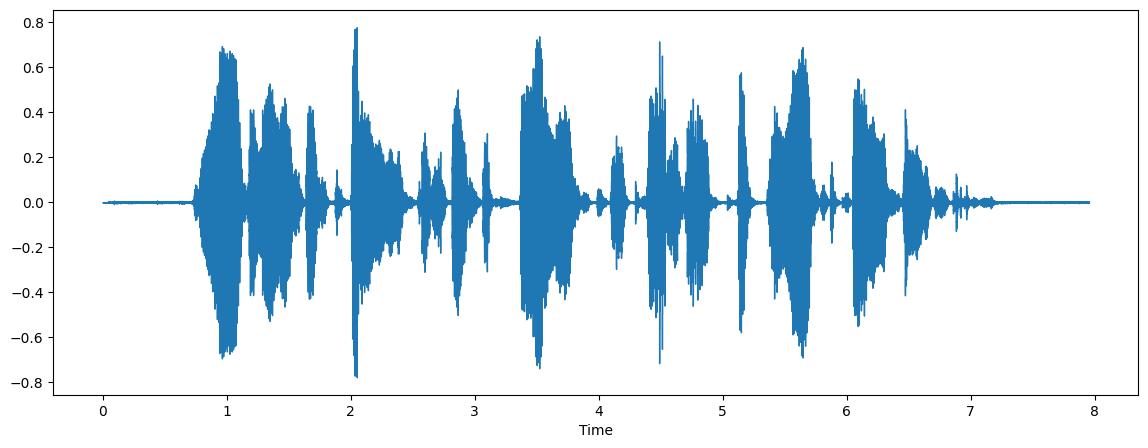

In [ ]:
sample, sr = librosa.load(real_sample)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample, sr=sr)

# Feature Extraction for Each Audio File

In [ ]:
def get_features(file_path):
    audio, sample_rate = librosa.load(file_path)
    stft = np.abs(librosa.stft(y=audio))

    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(S=stft, sr=sample_rate).T, axis=0)
    return mfcc, chroma, mel


## Audio Preprocessing

In [ ]:
generic_voices = os.listdir('/content/drive/MyDrive/MyTTSDataset_6/generated_speeches')
real_voices = os.listdir('/content/drive/MyDrive/common_voice_13_0')

In [ ]:
cloned_features = []
real_features = []

In [ ]:
for filename in real_voices:
    path = '/content/drive/MyDrive/common_voice_13_0/'
    real_features.append(get_features(path + filename))


In [ ]:
for filename in generic_voices:
    path = '/content/drive/MyDrive/MyTTSDataset_6/generated_speeches/'
    cloned_features.append(get_features(path + filename))

In [ ]:
## Concatenate arrays for each file to have a single array for each audio file
real_features = [np.concatenate((i[0], i[1], i[2]), axis=0) for i in real_features]
cloned_features = [np.concatenate((i[0], i[1], i[2]), axis=0) for i in cloned_features]


In [ ]:
np.array(real_features).shape

(1000, 180)

In [ ]:
np.array(cloned_features).shape

(425, 180)

# Train Test Split

In [ ]:
X = np.append(real_features, cloned_features, axis=0)
y = np.append(np.zeros(len(real_features)), np.ones(len(cloned_features)), axis=0).reshape(1425, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, stratify=y_train, random_state=10)


In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (997, 180)
X_test shape: (285, 180)
X_val shape: (143, 180)


In [ ]:
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_val shape: {y_val.shape}')

y_train shape: (997, 1)
y_test shape: (285, 1)
y_val shape: (143, 1)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Modeling

In [ ]:
model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(180,)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               46336     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score(threshold=0.5)])
results = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=5)])

Epoch 1/100
32/32 [==============================] - 4s 28ms/step - loss: 0.3985 - f1_score: 0.7549 - val_loss: 0.1816 - val_f1_score: 0.9885
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.1389 - f1_score: 0.9346 - val_loss: 0.0737 - val_f1_score: 0.9885
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0705 - f1_score: 0.9702 - val_loss: 0.0376 - val_f1_score: 1.0000
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0607 - f1_score: 0.9734 - val_loss: 0.0206 - val_f1_score: 1.0000
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0376 - f1_score: 0.9833 - val_loss: 0.0123 - val_f1_score: 1.0000
Epoch 6/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0407 - f1_score: 0.9816 - val_loss: 0.0082 - val_f1_score: 1.0000
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0261 - f1_score: 0.9899 - val_loss: 0.0068 - val_f1_score: 1.0000
Epoch 8/

# Loss Function Plot

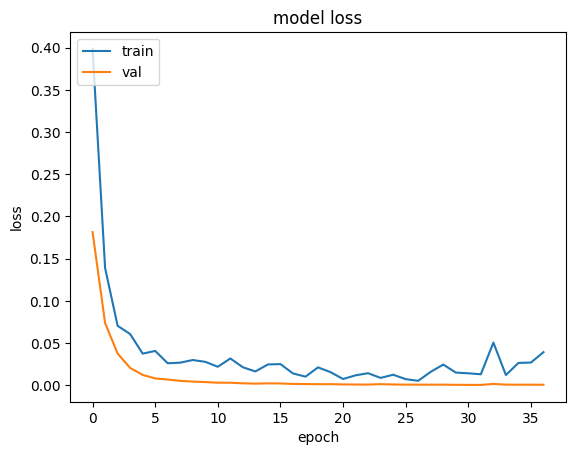

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# F1 Score Plot during Training Process

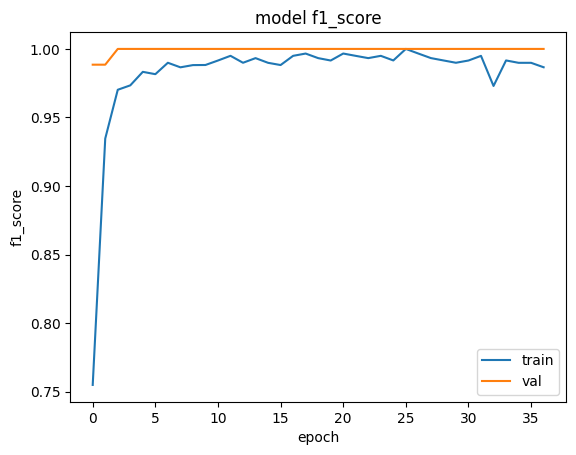

In [ ]:
plt.plot(results.history['f1_score'])
plt.plot(results.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Model Evaluation

In [ ]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 13ms/step - loss: 0.0193 - f1_score: 0.9942


[0.019345426931977272, array([0.99415207], dtype=float32)]

# Confusion Matrix and Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

9/9 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       200
         1.0       0.99      1.00      0.99        85

    accuracy                           1.00       285
   macro avg       0.99      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285



In [ ]:
ann_matrix = confusion_matrix(y_test, y_pred)

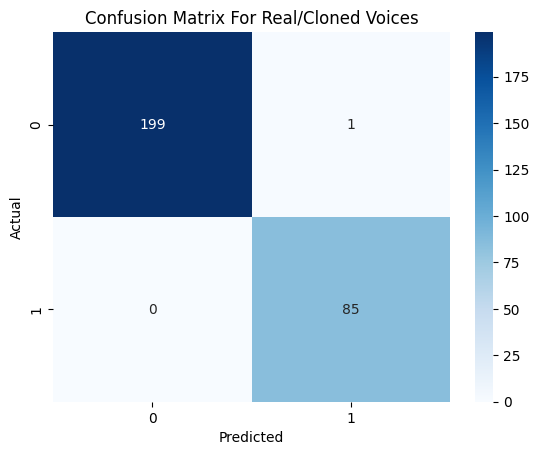

In [ ]:
import seaborn as sns
sns.heatmap(ann_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Real/Cloned Voices')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Conclusion
The neural network was able to distinguish real voice from fake ones with an f1 score of 99.42%, only one false positive. Future iterations of the project will explore drawing more random samples of real voices from the common voice data. Because I was constrained with processing power, I was only able to draw about 1% of the original data.  